In [2]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical

In [3]:
confidence_level = 0.90
num_realizations = 100
seed = 12
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/'
folder_path_simex = folder_path+'simex/exponential_classical_unifstart/'

In [4]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3

In [5]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

In [6]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) #a + b*x + c*x**2

In [20]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
counts = np.zeros((num_scales, len(theta_star)))
coverage_probabilities = np.zeros((num_scales, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed = 12
    for r in range(num_realizations):
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, x = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        #mean_simex_sample = simex_sample.mean(axis=0)
        initial_guess = [-1,4] #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((simex_sample - theta_star)**2)
        mses[j, r, 2, :] = np.asarray((ls_estimator - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[j, i] += count
            
    # Calculate the coverage probability
    coverage_probabilities[j, :] = counts[j, :] / num_realizations
    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[j, 0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[j, 1] * 100}%")
    #print(f"Coverage Probability for theta_3 for ME std {scale_nu}: {coverage_probabilities[2] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for SIMEX: {mses_over_runs[j, 1, :]}")
    print(f"Mean Squared error for Least Squares: {mses_over_runs[j, 2, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for SIMEX: {stds_mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 2, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 97.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.08257133 0.05090182]
Mean Squared error for SIMEX: [0.09691478 0.2136008 ]
Mean Squared error for Least Squares: [0.09690033 0.21358637]
Std - Mean Squared error for Robust-MEM: [0.11065309 0.06794846]
Std - Mean Squared error for SIMEX: [0.1825758  0.28283215]
Std - Mean Squared error for Least Squares: [0.18246919 0.28279902]
Coverage Probability for theta_1 for ME std 0.5: 96.0%
Coverage Probability for theta_2 for ME std 0.5: 100.0%
Mean Squared error for Robust-MEM: [0.0901731 0.053792 ]
Mean Squared error for SIMEX: [0.09437738 0.26455918]
Mean Squared error for Least Squares: [0.09168523 0.53531416]
Std - Mean Squared error for Robust-MEM: [0.12007947 0.06706851]
Std - Mean Squared error for SIMEX: [0.13392868 0.31347304]
Std - Mean Squared error for Least Squares: [0.12045636 0.40808575]
Coverage Probability for theta_1 for ME 

### Make a table

In [8]:
import pandas as pd

/tmp/dcs-tmp.u1604520/ipykernel_253853/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Coverage probabilities for Robust MEM

In [27]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    data_coverage = {'Param': ['$\theta_1$', '$\theta_2$'], 'Coverage prob.': coverage_probabilities[i, :], '$\sigma_\nu$': scale_nu}
    df = pd.DataFrame(data_coverage)
    dfs.append(df)
cov_df = pd.concat(dfs, ignore_index=True)
cov_gb = cov_df.groupby((['Param', '$\sigma_\nu$'])).mean()
pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
pivot_cov

Coverage prob.                           
$\sigma_
u$       0.000001 0.500000 1.000000 2.000000
Param                                                
$\theta_1$            0.97     0.96     0.96     0.95
$\theta_2$            1.00     1.00     1.00     1.00

MSE and STD

In [9]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [10]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [11]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'SIMEX')
    dfs.append(df)
simex_df = pd.concat(dfs, ignore_index=True)

In [12]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,2,:], stds_mses_over_runs[i,2,:], scale_nu, 'LS')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [13]:
df_all = pd.concat([robustmem_df, simex_df, ls_df])

In [14]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,0.082571,0.110653,0.000001,Robust-MEM (MMD)
1,$\theta_2$,0.050902,0.067948,0.000001,Robust-MEM (MMD)
2,$\theta_1$,0.090173,0.120079,0.500000,Robust-MEM (MMD)
3,$\theta_2$,0.053792,0.067069,0.500000,Robust-MEM (MMD)
4,$\theta_1$,0.097481,0.130820,1.000000,Robust-MEM (MMD)
5,$\theta_2$,0.055466,0.069911,1.000000,Robust-MEM (MMD)
6,$\theta_1$,0.103168,0.140334,2.000000,Robust-MEM (MMD)
7,$\theta_2$,0.054493,0.066877,2.000000,Robust-MEM (MMD)
0,$\theta_1$,0.096915,0.182576,0.000001,SIMEX
1,$\theta_2$,0.213601,0.282832,0.000001,SIMEX


In [15]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [16]:
pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,LS,$\theta_1$,0.096900,0.182469,0.091685,0.120456,0.133400,0.152186,0.181570,0.169179
1,LS,$\theta_2$,0.213586,0.282799,0.535314,0.408086,1.696119,0.482644,3.083794,0.325153
2,Robust-MEM (MMD),$\theta_1$,0.082571,0.110653,0.090173,0.120079,0.097481,0.130820,0.103168,0.140334
3,Robust-MEM (MMD),$\theta_2$,0.050902,0.067948,0.053792,0.067069,0.055466,0.069911,0.054493,0.066877
4,SIMEX,$\theta_1$,0.096915,0.182576,0.094377,0.133929,0.122189,0.166302,0.122189,0.166302
5,SIMEX,$\theta_2$,0.213601,0.282832,0.264559,0.313473,0.881177,0.560570,0.881177,0.560570


In [17]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5   Std-0.5  \
Method           Param                                                  
LS               $\theta_1$   0.096900   0.182469  0.091685  0.120456   
                 $\theta_2$   0.213586   0.282799  0.535314  0.408086   
Robust-MEM (MMD) $\theta_1$   0.082571   0.110653  0.090173  0.120079   
                 $\theta_2$   0.050902   0.067948  0.053792  0.067069   
SIMEX            $\theta_1$   0.096915   0.182576  0.094377  0.133929   
                 $\theta_2$   0.213601   0.282832  0.264559  0.313473   

                              MSE-1.0   Std-1.0   MSE-2.0   Std-2.0  
Method           Param                                               
LS               $\theta_1$  0.133400  0.152186  0.181570  0.169179  
                 $\theta_2$  1.696119  0.482644  3.083794  0.325153  
Robust-MEM (MMD) $\theta_1$  0.097481  0.130820  0.103168  0.140334  
                 $\theta_2$  0.055466  0.069911  0.054493  0.066877  
SIMEX            $\theta_1$  0.122189  0.166302  0.122189  0.166302  
                 $\theta_2$  0.881177  0.560570  0.881177  0.560570

In [18]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5, 1.0, 2.0]
# Iterate over columns
for i, nu in enumerate(nus):  # Assuming you have two pairs a_i and b_i
    # Extract corresponding pairs
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    # Concatenate values for the title
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

$\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  \
Method           Param                                                
LS               $\theta_1$        0.097 (0.182)       0.092 (0.12)   
                 $\theta_2$        0.214 (0.283)      0.535 (0.408)   
Robust-MEM (MMD) $\theta_1$        0.083 (0.111)        0.09 (0.12)   
                 $\theta_2$        0.051 (0.068)      0.054 (0.067)   
SIMEX            $\theta_1$        0.097 (0.183)      0.094 (0.134)   
                 $\theta_2$        0.214 (0.283)      0.265 (0.313)   

                            $\sigma_\nu = 1.0$ $\sigma_\nu = 2.0$  
Method           Param                                             
LS               $\theta_1$      0.133 (0.152)      0.182 (0.169)  
                 $\theta_2$      1.696 (0.483)      3.084 (0.325)  
Robust-MEM (MMD) $\theta_1$      0.097 (0.131)       0.103 (0.14)  
                 $\theta_2$       0.055 (0.07)      0.054 (0.067)  
SIMEX            $\theta_1$      0.122 (0.166)      0.122 (0.166)  
                 $\theta_2$      0.881 (0.561)      0.881 (0.561)

In [19]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llllll}
\toprule
 &  & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ & $\sigma_
u = 1.0$ & $\sigma_
u = 2.0$ \\
Method & Param &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{LS} & $	heta_1$ & 0.097 (0.182) & 0.092 (0.12) & 0.133 (0.152) & 0.182 (0.169) \\
 & $	heta_2$ & 0.214 (0.283) & 0.535 (0.408) & 1.696 (0.483) & 3.084 (0.325) \\
\cline{1-6}
\multirow[t]{2}{*}{Robust-MEM (MMD)} & $	heta_1$ & 0.083 (0.111) & 0.09 (0.12) & 0.097 (0.131) & 0.103 (0.14) \\
 & $	heta_2$ & 0.051 (0.068) & 0.054 (0.067) & 0.055 (0.07) & 0.054 (0.067) \\
\cline{1-6}
\multirow[t]{2}{*}{SIMEX} & $	heta_1$ & 0.097 (0.183) & 0.094 (0.134) & 0.122 (0.166) & 0.122 (0.166) \\
 & $	heta_2$ & 0.214 (0.283) & 0.265 (0.313) & 0.881 (0.561) & 0.881 (0.561) \\
\cline{1-6}
\bottomrule
\end{tabular}



Plot

In [32]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [173]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


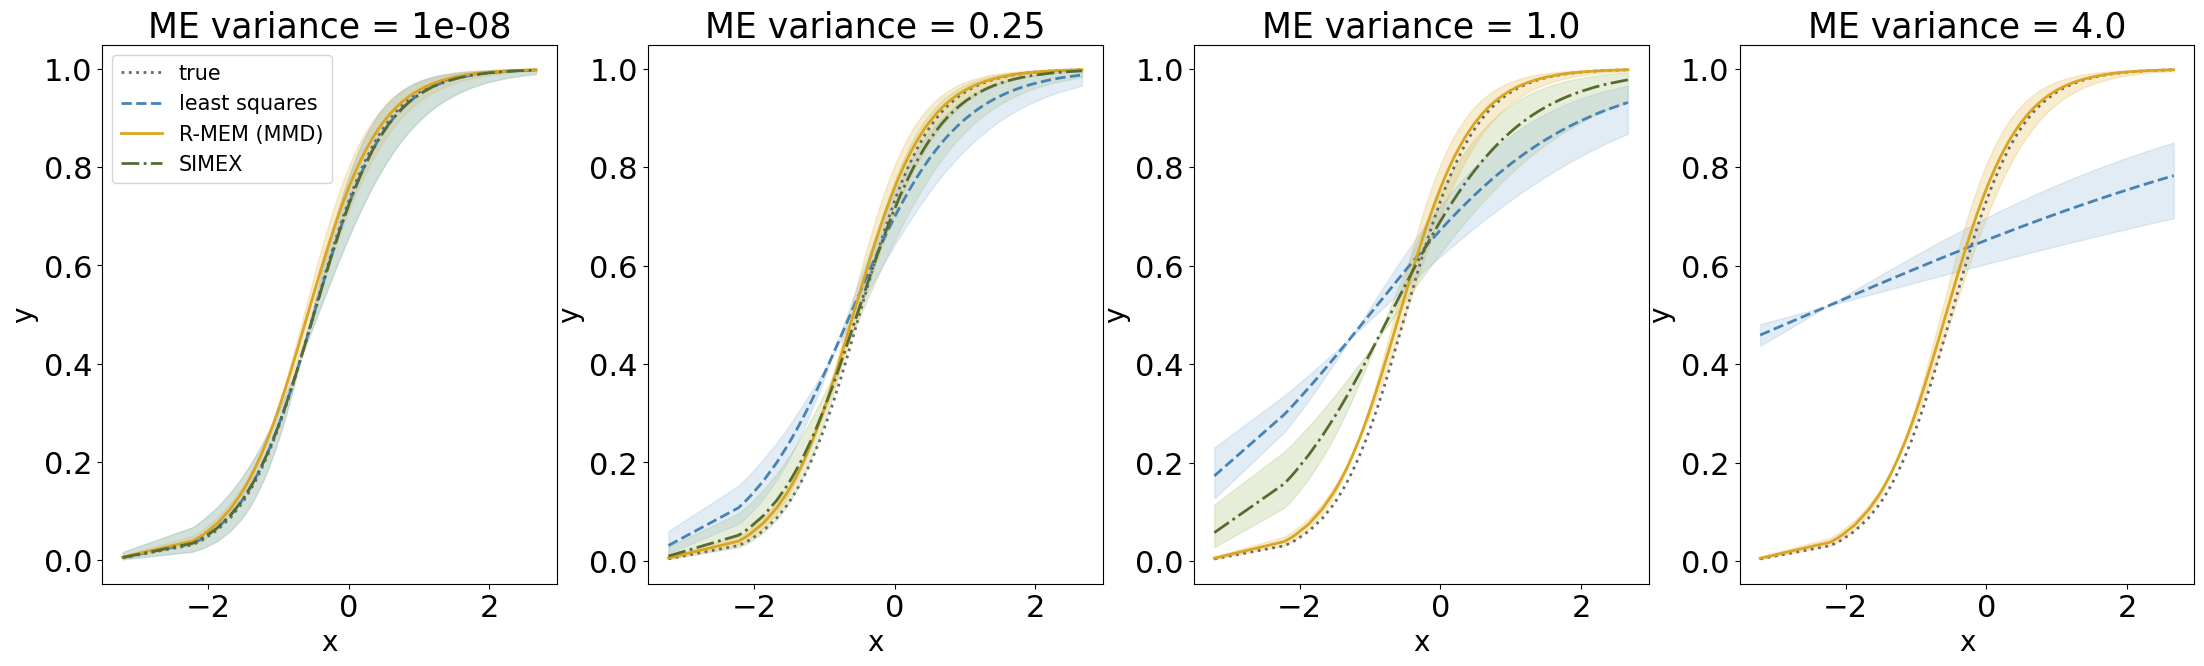

In [64]:
import matplotlib.pyplot as plt
num_methods = 3
num_realizations = 100
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 200
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed = 12
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        initial_guess = [0,0] #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = simex_sample
        thetas_over_run[:, 2, r] = ls_estimator
        xis_star_sorted = np.sort(xis_star)
        regs[r,0,:] = reg_func(thetas_over_run[:,0,r], xis_star_sorted)
        regs[r,1,:] = reg_func(thetas_over_run[:,1,r], xis_star_sorted)
        regs[r,2,:] = reg_func(thetas_over_run[:,2,r], xis_star_sorted)
        
    # lower_bounds[0, :] = np.percentile(regs[:,0,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[0, :] = np.percentile(regs[:,0,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[0, :] = np.mean(regs[:,0,:], axis=0)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    # lower_bounds[1, :] = np.percentile(regs[:,1,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[1, :] = np.percentile(regs[:,1,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[1, :] = np.mean(regs[:,1,:], axis=0)
    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    # lower_bounds[2, :] = np.percentile(regs[:,2,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[2, :] = np.percentile(regs[:,2,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[2, :] = np.mean(regs[:,2,:], axis=0)
    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    Y_real = reg_func(theta_star, xis_star_sorted)
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='true', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[2,:], linestyle='dashed', label='least squares', color='#4682B4', lw=2)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
    if scale_nu != 2.0:
        ax.plot(xis_star_sorted, means[1, :], linestyle='dashdot', label='SIMEX',color='#556B2F', lw=2)
        ax.fill_between(xis_star_sorted, lower_bounds[1, :], upper_bounds[1, :], color=lighten_color('#556B2F'), alpha=0.3)

    ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    if j == 0:
        ax.legend(fontsize=15)

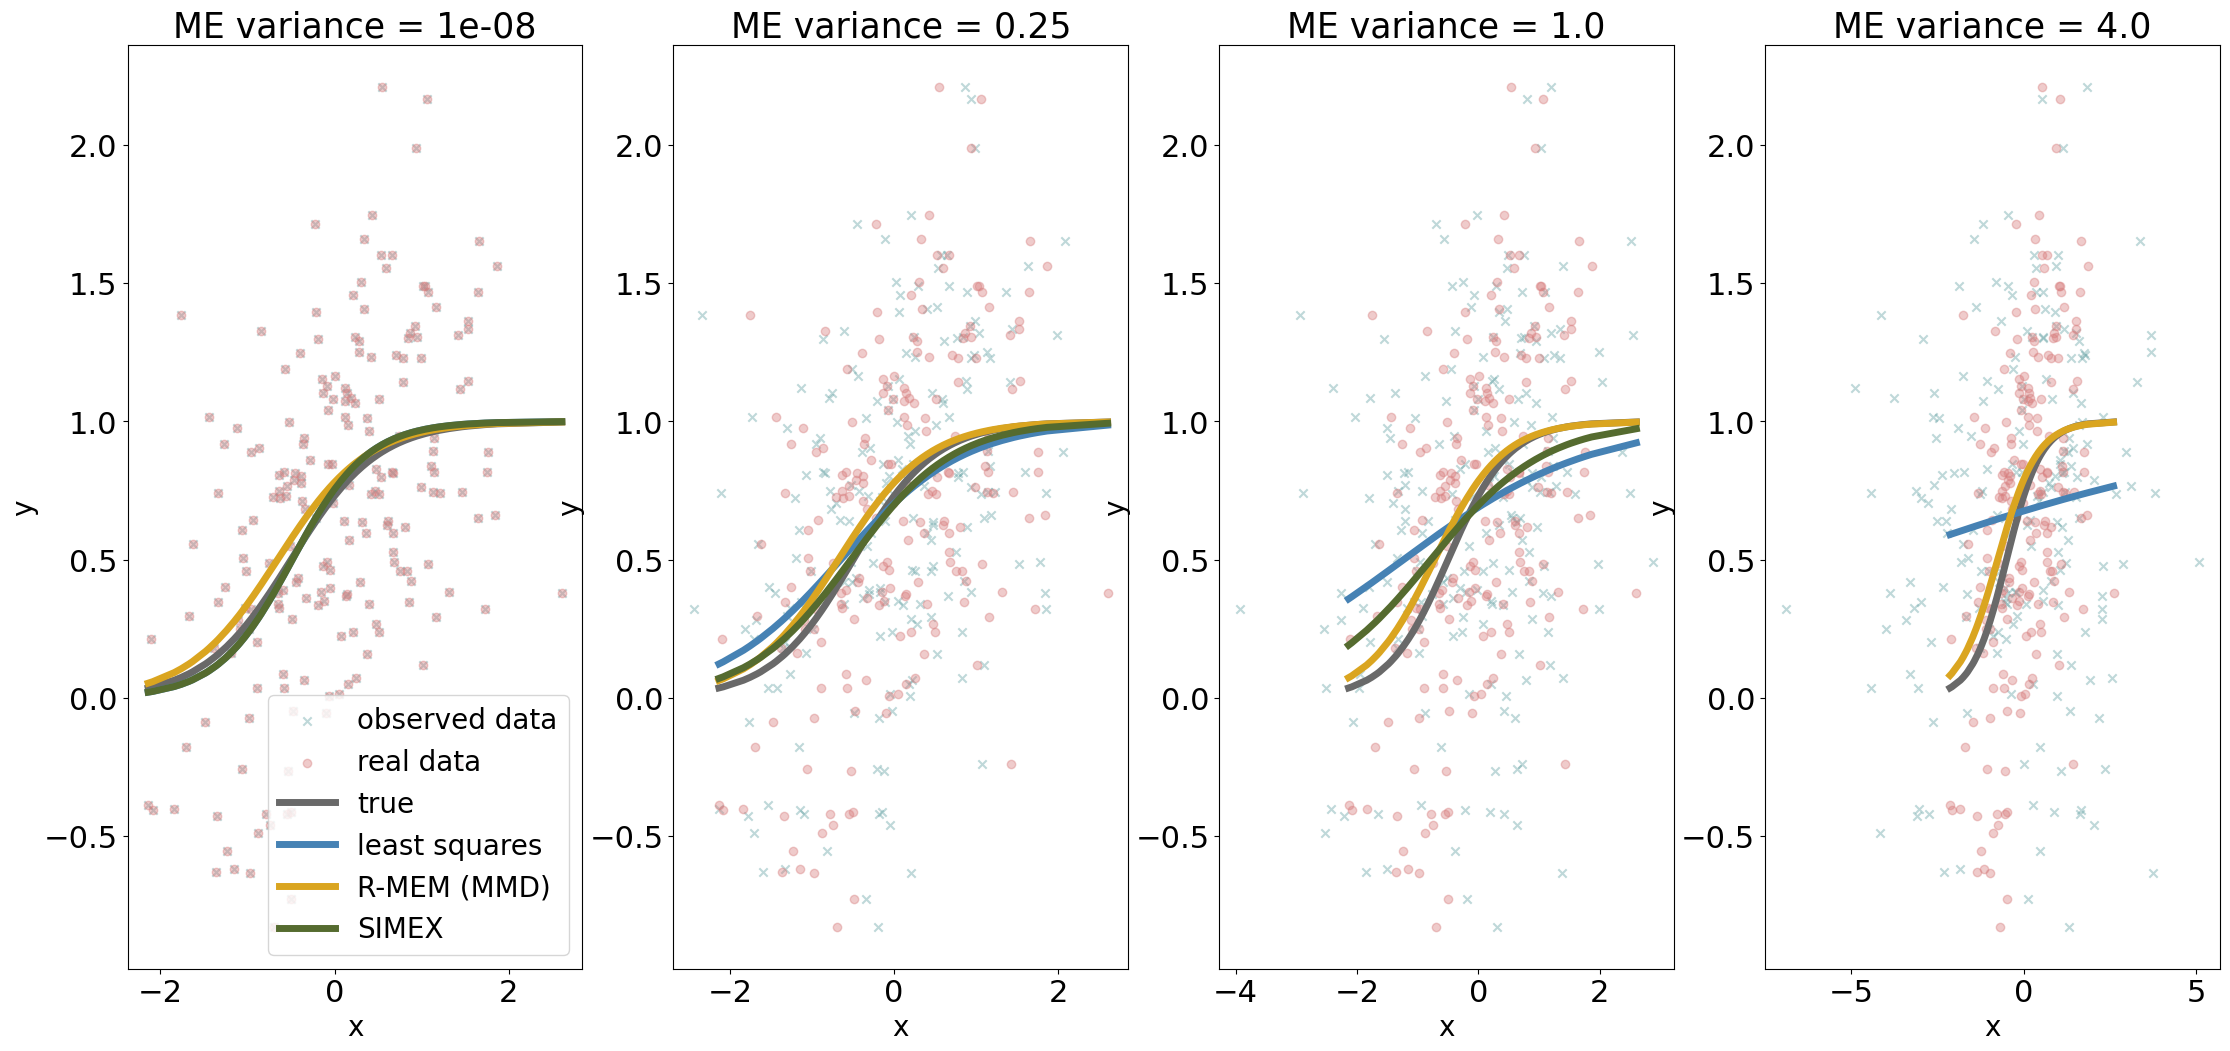

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

num_thetas = 2
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,12))
seed = 14

for ax, i in zip(ax_array.flatten(), range(0, num_scales)):
  scale_nu = scales_nu[i]
  boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
  thetas = np.mean(boot_sample, axis=0).flatten()
  if scale_nu == 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
  elif scale_nu != 2.0 and scale_nu != 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
  
  data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)
  initial_guess = [0,0] #[0, 4]  # Initial parameter guess
  ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
  
  # # Credible intervals
  # credible_interval = 0.90
  # regs = np.zeros((B,len(xis_star)))
  # for b in range(B):
  #   regs[b,:] = reg_func(thetas_all[b,:], xis_star)
  # lower_bound = np.percentile(regs, (1 - credible_interval) / 2 * 100, axis=1)
  # upper_bound = np.percentile(regs, (1 + credible_interval) / 2 * 100, axis=1)
  

  Y = reg_func(thetas, xis_star)
  Y_real = reg_func(theta_star, xis_star)
  Y_ls = reg_func(ls_estimator, xis_star)
  Y_simex = reg_func(simex_sample, xis_star)

  ax.scatter(data[:,0],data[:,1], marker="x", label='observed data', color='cadetblue', alpha=0.4)
  ax.scatter(xis_star, data[:,1], marker = "o", label='real data', color=lighten_color('indianred',amount=0.8), alpha=0.4)

  x,y = sort_array(xis_star, Y_real)
  ax.plot(x,y, label='true', color='dimgrey', lw=5)
  x,y = sort_array(xis_star, Y_ls)
  ax.plot(x,y, label='least squares', color='#4682B4', lw=5)
  x,y = sort_array(xis_star, Y)
  ax.plot(x,y, label='R-MEM (MMD)', color='goldenrod',lw=5)
  if scale_nu != 2.0:
    x,y = sort_array(xis_star, Y_simex)
    ax.plot(x,y, label='SIMEX',color='#556B2F', lw=5)
  # ax.plot(xis_star,Y, label='R-MEM (MMD)', color='goldenrod',lw=6)
  #x,y1,y2 = sort_array2(xis_star, lower_bound, upper_bound)
  #ax.fill_between(x, y1, y2, color="pink", alpha=0.3, label=f"{credible_interval * 100}% Credible Intervals")
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)
  ax.patch.set_facecolor('white')
  if i == 0:
    ax.set_title(f'ME variance = 1e-08', fontsize=25)
  elif i == 1 or i == 3:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
  elif i == 2:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

  ax.set_xlabel('x',fontsize=20)
  ax.set_ylabel('y',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=22)
  ax.tick_params(axis='both', which='minor', labelsize=22)
  if i == 0:
    ax.legend(fontsize=20)

